In [12]:
!pip install PyPDF2
!pip install --upgrade gensim
!pip install nltk
!pip install numpy
!pip install pyldavis


In [15]:
#IMPORTAÇÕES
import PyPDF2 #BIBLIOTECA PARA MANIPULAR PDFs
import gensim #BIBLIOTECA PARA GERAÇÃO DE TÓPICOS E SUAS SIMILARIDADES
from gensim import corpora #CORPORA É PARA TOKENIZAR PALAVRAS 
from gensim.models import LdaModel #TRAZENDO O MODELO Latent Dirichlet Allocation (LDA)
from gensim.utils import simple_preprocess #módulo para escolher tokens não muito longos e nem muito curtos
from nltk.corpus import stopwords #MÓDULO STOPWORDS PARA ACHAR E REMOVER PALAVRAS DESINTERESSANTES (CONNECTIVOS E AFINS)
from nltk.stem import WordNetLemmatizer #MÓDULO PARA REMOVER PALAVRAS NO PLURAL
import os #MÓDULO PARA MANIPULAR SISTEMA OPERACIONAL
import nltk
import pyLDAvis.gensim #MÓDULO PARA VISUALIZAR O RESULTADO DA APLICAÇÃO DO LDA NO FORMATO GENSIM
import pickle #BIBLIOTECA PARA SERIALIZAR (OU SEJA, GUARDAR E LER MULTIPLOS DADOS DE LISTAS NO FORMATO PKL)
import pyLDAvis #MÓDULO PARA VISUALIZAR O RESULTADO DA APLICAÇÃO DO LDA 
import warnings #MÓDULO MOSTRAR ERROS OU AVISOS IMPORTANTES

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning) #IGNORAR ERROS DE BIBLIOTECAS DESCONTINUADAS OU ANTIGAS
nltk.download('stopwords') #BAIXANDO AS STOPWORDS
nltk.download('wordnet') #BAIXANDO A REDE DE PALAVRAS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GSF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GSF\AppData\Roaming\nltk_data...


True

In [24]:
# Function to extract text from PDF
def extract_text_from_pdf(file_path): #DECLARAÇÃO DA FUNÇÃO, RECEBENDO PARAMETRO O CAMINHO DO PDF
    with open(file_path, 'rb') as file: #ABRIR UM ARQUIVO QUE ESTÁ NO CAMINHO DO PARAMETRO, E REFERENCIAR NA VARIAVEL "FILE"
        reader = PyPDF2.PdfReader(file) #LENDO O PDF PASSANDO A VARIAVEL "FILE"
        num_pages = len(reader.pages) #SABENDO O NUMERO MÁXIMO DE PÁGINAS
        text = "" #TEXTO VAZIO
        for page in range(num_pages): #LOOP, NO QUAL, LER CADA PÁGINA ATÉ A ÚLTIMA
            page_obj = reader.pages[page] #PEGANDO O TEXTO DA PÁGINA, INICIANDO PELA PÁGINA 0 (ou seja a primeira página)
            text += page_obj.extract_text() #ACUMULANDO TEXTOS A CADA INTERAÇÃO (A CADA LOOP)
        return text #RETORNA O TEXTO INTEIRO DO DOCUMENTO

In [25]:
# Function for text preprocessing
def preprocess_text(text): #DECLARAÇÃO DA FUNÇÃO, RECEBENDO COMO PARAMETRO, O TEXTO
    # Tokenize and clean the text
    tokens = simple_preprocess(text, deacc=True) #PASSANDO O TEXTO, GERAR TOKENS COM LETRAS MINUSCULAS, 
    #IGNORANDO EXTREMOS, REMOVENDO ACENTOS

    # Remove stop words
    stop_words = set(stopwords.words('english')) #PEGANDO AS STOPWORDS DO VOCABULÁRIO INGLÊS
    tokens = [token for token in tokens if token not in stop_words] #LOOP DE SEPARAR OS TOKENS QUE NÃO SÃO STOPWORDS

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer() # Criar uma variavel para a técnica Lemmatizer 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  #reduzir as palavras à sua forma raiz, passando cada token

    return tokens #RETORNA OS TOKENS PRÉ-PROCESSADOS

In [19]:
# Load PDF and extract text

pdf_file_path = 'C:\\Users\\GSF\\Downloads\\HM_Group_SustainabilityReport_2018_-FullReport (1).pdf' #CAMINHO ABSOLUTO DO ARQUIVO QUE SERÁ ANALISADO
document_text = extract_text_from_pdf(pdf_file_path) #RETORNA O TEXTO EXTRAIDO E GUARDA NA VARIAVEL document_text
print(document_text)

Sustainability Report 2018H&M GROUP SUSTAINABILITY REPORT 20182 OF 109
OVERVIEWHOW WE REPORT STANDARDS & POLICIES VISION & STRATEGY 100% LEADING THE CHANGE 100% CIRCULAR & RENEWABLE 100% FAIR & EQUALTable of contents
1. OVERVIEW 3
Letter from CEO 4
Executive summary 6
Key Achievements 2018 7
Awards & recognitions 9
About H&M Group 10
Our value chain 11
2. VISION & STRATEGY 12
Our vision & strategy 13
Our ambitions 14
Our Change-Making Programme 15
How we are organised 16
Engaging our changemakers 17
Interview with Head of Sustainability 18
3. 100% LEADING THE CHANGE 19
Key facts & figures 2018 20
100% Leading the Change explained 21
Innovation 22
Transparency 25
Rewarding sustainable actions 29
4. 100% CIRCULAR & RENEWABLE 30
Key facts & figures 2018 31
KPIs and goals 32
100% Circular & Renewable explained 33
Becoming climate positive 535. 100% FAIR & EQUAL 60
Key facts & figures 2018 61
KPIs and goals 62
100% Fair & Equal explained 63
Fair jobs for all 64
Enabling well-functioning ind

In [37]:
# Preprocess the text
processed_text = preprocess_text(document_text) #RETORNA OS TOKENS FINAIS E GUARDA NA VARIAVEL processed_text
print(processed_text)

 

['sustainability', 'report', 'group', 'sustainability', 'report', 'overviewhow', 'report', 'standard', 'policy', 'vision', 'strategy', 'leading', 'change', 'circular', 'renewable', 'fair', 'equaltable', 'content', 'overview', 'letter', 'ceo', 'executive', 'summary', 'key', 'achievement', 'award', 'recognition', 'group', 'value', 'chain', 'vision', 'strategy', 'vision', 'strategy', 'ambition', 'change', 'making', 'programme', 'organised', 'engaging', 'changemakers', 'interview', 'head', 'sustainability', 'leading', 'change', 'key', 'fact', 'figure', 'leading', 'change', 'explained', 'innovation', 'transparency', 'rewarding', 'sustainable', 'action', 'circular', 'renewable', 'key', 'fact', 'figure', 'kpis', 'goal', 'circular', 'renewable', 'explained', 'becoming', 'climate', 'positive', 'fair', 'equal', 'key', 'fact', 'figure', 'kpis', 'goal', 'fair', 'equal', 'explained', 'fair', 'job', 'enabling', 'well', 'functioning', 'industrial', 'relation', 'supporting', 'fair', 'living', 'wage', 

In [38]:
# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary([processed_text]) #INSTANCIAR UM OBJETO (VARIAVEL) PARA A CLASSE DICTIONARY (PARA ESTRUTURAÇÃO DOS DADOS)
corpus = [dictionary.doc2bow(processed_text)] #APLICAR O BAF-OF-WORDS, E RETORNAR AS QUANTIDADES DE CADA TOKEN EM FORMA DE VETOR
print(corpus)
print(len(corpus[0]))

[[(0, 6), (1, 8), (2, 12), (3, 4), (4, 1), (5, 1), (6, 4), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 8), (14, 3), (15, 1), (16, 2), (17, 2), (18, 2), (19, 1), (20, 2), (21, 1), (22, 7), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 14), (29, 10), (30, 20), (31, 4), (32, 8), (33, 1), (34, 2), (35, 1), (36, 2), (37, 2), (38, 2), (39, 2), (40, 34), (41, 9), (42, 18), (43, 13), (44, 2), (45, 48), (46, 2), (47, 28), (48, 76), (49, 1), (50, 1), (51, 1), (52, 3), (53, 4), (54, 5), (55, 2), (56, 14), (57, 8), (58, 2), (59, 1), (60, 1), (61, 1), (62, 4), (63, 2), (64, 7), (65, 6), (66, 36), (67, 3), (68, 39), (69, 1), (70, 1), (71, 1), (72, 2), (73, 3), (74, 2), (75, 1), (76, 1), (77, 1), (78, 6), (79, 8), (80, 1), (81, 4), (82, 3), (83, 1), (84, 2), (85, 1), (86, 1), (87, 4), (88, 6), (89, 3), (90, 2), (91, 7), (92, 2), (93, 1), (94, 2), (95, 1), (96, 3), (97, 1), (98, 9), (99, 2), (100, 3), (101, 7), (102, 1), (103, 2), (104, 3), (105, 9), (106, 1), (107, 1), (108, 1), (109,

In [40]:
# Perform topic modeling
num_topics = 3  # Number of desired topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)#INSTANCIAR UM OBJETO LDAMODEL, 
#PASSANDO PARAMETROS DE CRIAÇÃO DO MODELO LDA. 
print(lda_model)

LdaModel<num_terms=3950, num_topics=3, decay=0.5, chunksize=2000>


In [41]:
# Print the topics
for topic in lda_model.print_topics(num_words=5):
    print(topic) #MOSTRAR OS TÓPICOS E SEUS PESOS

(0, '0.011*"group" + 0.010*"report" + 0.009*"fair" + 0.009*"circular" + 0.008*"policy"')
(1, '0.012*"report" + 0.011*"group" + 0.009*"fair" + 0.008*"wage" + 0.007*"sustainability"')
(2, '0.012*"group" + 0.011*"fair" + 0.009*"sustainability" + 0.008*"policy" + 0.008*"circular"')


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook() #PERMITINDO A BIBLIOTECA pyLDAvis no notebook
LDAvis_data_filepath = os.path.join('C:\\Users\\GSF\\Downloads\\ldavis_prepared_'+str(num_topics)) #GUARDADNO O CAMINHO

In [43]:
# Prepare the data for visualization
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary) #PREPARANDO OS DADOS PARA VISUALIZAR, INFORMANDO O MODELO CRIADO
#INFORMANDO O CORPUS E O DICIONARIO ESTRUTURADO

In [44]:
# Save the prepared pyLDAvis data to a file
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [45]:
# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

In [46]:
# Save the pyLDAvis visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\GSF\\Downloads\\ldavis_prepared_'+ str(num_topics) +'.html')
# Display the pyLDAvis visualization
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003619  0.000987       1        1  88.974769
0     -0.000573 -0.002661       2        1   9.736142
1     -0.003046  0.001674       3        1   1.289088, topic_info=                Term        Freq       Total Category  logprob  loglift
1555           group  331.000000  331.000000  Default  30.0000  30.0000
3002          report  229.000000  229.000000  Default  29.0000  29.0000
1330            fair  300.000000  300.000000  Default  28.0000  28.0000
3491  sustainability  247.000000  247.000000  Default  27.0000  27.0000
554         circular  227.000000  227.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2018         leading    1.460192  152.268159   Topic3  -5.5056  -0.2958
1671           human    1.290236  122.744044   Topic3  -5.6293  -0.2040
3408        strategy    1.310491  132.371261   Topic3  -5.6137  -0.2640
3914            work    1.334215  144.788559   Topic3  -5.5958  -0.3357
3916          worker    1.277461  126.925838   Topic3  -5.6393  -0.2475

[263 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
45        1  0.924247     across
45        2  0.060277     across
45        3  0.020092     across
53        1  0.828592     active
53        2  0.276197     active
...     ...       ...        ...
3919      1  0.856244  workplace
3919      2  0.107030  workplace
3938      1  0.917529       year
3938      2  0.069686       year
3938      3  0.011614       year

[362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

(0, '0.026*"energy" + 0.012*"year" + 0.010*"customer" + 0.010*"electric" + 0.008*"schneider"')
(1, '0.022*"energy" + 0.009*"year" + 0.007*"schneider" + 0.007*"electric" + 0.006*"customer"')
(2, '0.020*"energy" + 0.009*"year" + 0.009*"schneider" + 0.008*"customer" + 0.008*"electric"')


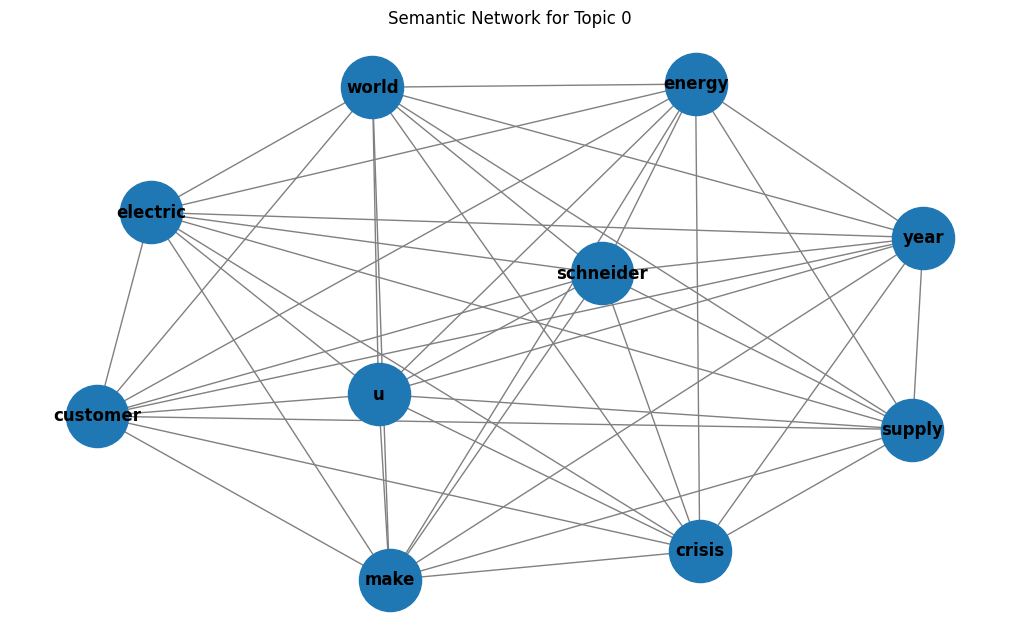

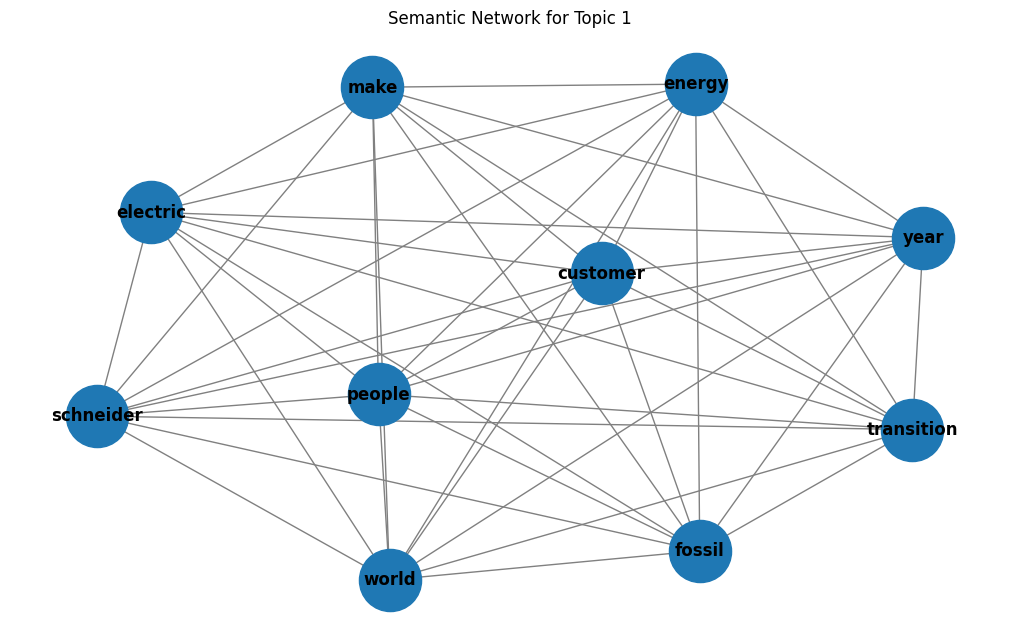

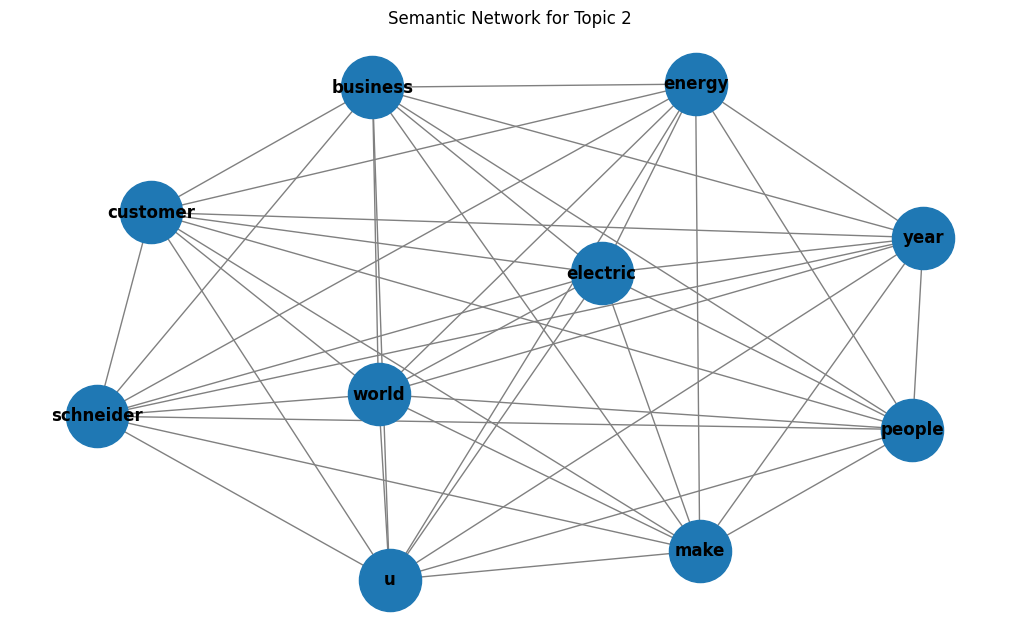

Top 10 Keywords:
energy: 33
year: 14
schneider: 11
electric: 11
customer: 11
world: 8
make: 8
supply: 7
people: 7
u: 7


In [10]:
#NÃO EXPLICADO AINDA

import PyPDF2
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import networkx as nx
import matplotlib.pyplot as plt
import operator

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)
        text = ""
        for page in range(num_pages):
            page_obj = reader.pages[page]
            text += page_obj.extract_text()
        return text

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize and clean the text
    tokens = simple_preprocess(text, deacc=True)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Load PDF and extract text
pdf_file_path = 'C:\\Users\\6675237\\Downloads\\se-ceo.pdf'
document_text = extract_text_from_pdf(pdf_file_path)

# Preprocess the text
processed_text = preprocess_text(document_text)

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary([processed_text])
corpus = [dictionary.doc2bow(processed_text)]

# Perform topic modeling
num_topics = 3  # Number of desired topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print the topics
for topic in lda_model.print_topics(num_words=5):
    print(topic)

# Generate and visualize semantic networks for each topic
for topic in range(num_topics):
    topic_word_network = nx.Graph()
    topic_words = lda_model.show_topic(topic, topn=10)  # Get the top words for the topic
    for i, (word, word_prob) in enumerate(topic_words):
        topic_word_network.add_node(word, weight=word_prob)
        for j in range(i + 1, len(topic_words)):
            other_word, other_word_prob = topic_words[j]
            topic_word_network.add_node(other_word, weight=other_word_prob)
            topic_word_network.add_edge(word, other_word)

    # Plot the semantic network for the topic
    pos = nx.spring_layout(topic_word_network, seed=42)  # Define the layout for consistent visualization
    plt.figure(figsize=(10, 6))
    nx.draw(topic_word_network, pos, with_labels=True, node_size=2000, font_size=12, font_weight='bold', edge_color='gray')
    plt.title(f"Semantic Network for Topic {topic}")
    plt.show()

# Keyword analysis
word_frequencies = {}
for token in processed_text:
    if token not in word_frequencies:
        word_frequencies[token] = 1
    else:
        word_frequencies[token] += 1

# Sort the word frequencies in descending order
sorted_word_frequencies = sorted(word_frequencies.items(), key=operator.itemgetter(1), reverse=True)

# Print the top 10 most frequent keywords
print("Top 10 Keywords:")
for word, frequency in sorted_word_frequencies[:10]:
    print(f"{word}: {frequency}")

In [12]:
import PyPDF2
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import pyLDAvis.gensim
import pickle
import pyLDAvis
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)
        text = ""
        for page in range(num_pages):
            page_obj = reader.pages[page]
            text += page_obj.extract_text()
        return text

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize and clean the text
    tokens = simple_preprocess(text, deacc=True)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Load PDF and extract text
pdf_file_path = 'C:\\Users\\6675237\\Downloads\\Unilever_2022.pdf'
document_text = extract_text_from_pdf(pdf_file_path)

# Preprocess the text
processed_text = preprocess_text(document_text)

# Define your desired keywords
keywords = ['sustainability', 'people', 'sustainable', 'green', 'circular', 'planet']

# Preprocess the keywords
processed_keywords = preprocess_text(' '.join(keywords))

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary([processed_keywords])
corpus = [dictionary.doc2bow(processed_keywords)]

# Perform topic modeling
num_topics = 3  # Number of desired topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print the topics
for topic in lda_model.print_topics(num_words=5):
    print(topic)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:\\Users\\6675237\\Downloads\\ldavis_prepared_'+str(num_topics))

# Prepare the data for visualization
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

# Save the prepared pyLDAvis data to a file
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Save the pyLDAvis visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, 'C:\\Users\\6675237\\Downloads\\ldavis_prepared_'+ str(num_topics) +'.html')

# Display the pyLDAvis visualization
LDAvis_prepared


(0, '0.177*"planet" + 0.170*"sustainability" + 0.168*"circular" + 0.165*"sustainable" + 0.161*"people"')
(1, '0.170*"planet" + 0.168*"sustainability" + 0.167*"circular" + 0.166*"sustainable" + 0.166*"people"')
(2, '0.170*"green" + 0.169*"people" + 0.167*"sustainable" + 0.166*"circular" + 0.165*"sustainability"')


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.000157  0.0       1        1  89.991439
0      0.000150  0.0       2        1   5.040248
1      0.000007  0.0       3        1   4.968314, topic_info=             Term      Freq     Total Category  logprob  loglift
3          planet  0.000000  0.000000  Default   6.0000   6.0000
4  sustainability  0.000000  0.000000  Default   5.0000   5.0000
0        circular  0.000000  0.000000  Default   4.0000   4.0000
5     sustainable  1.000000  1.000000  Default   3.0000   3.0000
2          people  1.000000  1.000000  Default   2.0000   2.0000
1           green  1.000000  1.000000  Default   1.0000   1.0000
1           green  0.918108  1.014892   Topic1  -1.7717   0.0052
2          people  0.911469  1.009511   Topic1  -1.7790   0.0033
5     sustainable  0.903987  1.003346   Topic1  -1.7872   0.0012
0        circular  0.897878  0.998324   Topic1  -1.7940  -0.0006
4  sustainability  0.891098  0.992768   Topic1  -1.8016  -0.0026
3          planet  0.876946  0.981158   Topic1  -1.8176  -0.0068
3          planet  0.053401  0.981158   Topic2  -1.7340   0.0768
4  sustainability  0.051551  0.992768   Topic2  -1.7692   0.0298
0        circular  0.050711  0.998324   Topic2  -1.7857   0.0078
5     sustainable  0.049832  1.003346   Topic2  -1.8031  -0.0147
2          people  0.048637  1.009511   Topic2  -1.8274  -0.0451
1           green  0.048283  1.014892   Topic2  -1.8347  -0.0577
3          planet  0.050812  0.981158   Topic3  -1.7693   0.0415
4  sustainability  0.050119  0.992768   Topic3  -1.7830   0.0160
0        circular  0.049735  0.998324   Topic3  -1.7907   0.0027
5     sustainable  0.049527  1.003346   Topic3  -1.7949  -0.0065
2          people  0.049405  1.009511   Topic3  -1.7974  -0.0151
1           green  0.048501  1.014892   Topic3  -1.8158  -0.0389, token_table=      Topic      Freq            Term
term                                 
0         1  1.001678        circular
1         1  0.985327           green
2         1  0.990578          people
3         1  1.019204          planet
4         1  1.007284  sustainability
5         1  0.996665     sustainable, R=6, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])